In [ ]:
# 1. LOAD AND INSPECT DATA
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Problem
Use the Planet Habitability Laboratory data (phl exoplanet catalog.csv) that
you inspected in the previous homework to build classifiers that predict planet habitability
based on three features: stellar mass, orbital period, and distance.

There are three target classes in the database: 0 (non-habitable), 1 (optimistically hab-
itable) and 2 (reasonably habitable).

You need to select the features and target classes from the database. For simplicity, treat
this as a binary classification problem, combining the two habitable classes into one.

Follow a similar procedure to the one for the MNIST dataset in the Geron book to train
a RandomForest and SGD classifier. Calculate the corresponding F1 scores and confusion
matrices. Construct the PR curves as in Figures 3-6 and 3-8 in the Geron book and comment
on which classifier is better.

___
---
* build classifiers that predict planet habitability based on three features: stellar mass, orbital period, and distance.
* treat this as a binary classification problem, combining the two habitable classes into one.
* RandomForest and SGD classifier
* Calculate the corresponding F1 scores and confusion matrices. Construct the PR curves as in Figures 3-6 and 3-8 in the Geron book and comment on which classifier is better.

# Prepare the data

In [ ]:
data_original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PHY391 MLPR/Data/phl_exoplanet_catalog.csv")
data_original.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


The columns needed are S_MASS, P_PERIOD, and P_DISTANCE.

In [ ]:
data = data_original[['P_NAME','S_MASS','P_PERIOD','P_DISTANCE', 'P_HABITABLE']]
data.head()

,P_NAME,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,11 Com b,2.70,326.03000,1.324418,0
1,11 UMi b,2.78,516.21997,1.534896,0
2,14 And b,2.20,185.84000,0.830000,0
3,14 Her b,0.90,1773.40000,3.130558,0
4,16 Cyg B b,1.08,798.50000,2.043792,0


In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3180 entries, 0 to 4047
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   P_NAME       3180 non-null   object 
 1   S_MASS       3180 non-null   float64
 2   P_PERIOD     3180 non-null   float64
 3   P_DISTANCE   3180 non-null   float64
 4   P_HABITABLE  3180 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 149.1+ KB


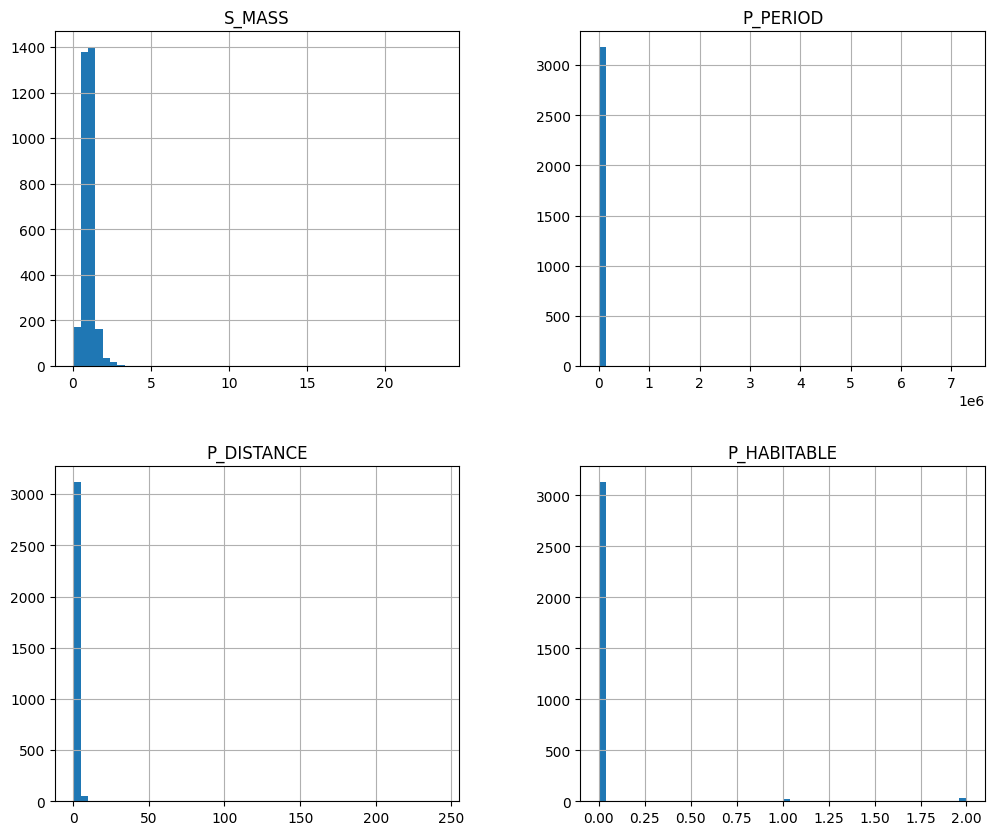

In [ ]:
data.hist(bins=50,figsize=(12,10));

In [ ]:
# transform the features with log and categorize the lables
log_transformer = FunctionTransformer(np.log)
data[['S_MASS_log','P_PERIOD_log','P_DISTANCE_log']] = log_transformer.fit_transform(data[['S_MASS','P_PERIOD','P_DISTANCE']])
data['P_HABITABLE_cat'] = (data['P_HABITABLE'] > 0).astype(int)

data_rescaled = data[['S_MASS_log','P_PERIOD_log','P_DISTANCE_log', 'P_HABITABLE_cat']].copy()

In [ ]:
data_rescaled.head()

,S_MASS_log,P_PERIOD_log,P_DISTANCE_log,P_HABITABLE_cat
0,0.993252,5.786989,0.280973,0
1,1.022451,6.246533,0.428463,0
2,0.788457,5.224886,-0.186330,0
3,-0.105361,7.480654,1.141211,0
4,0.076961,6.682735,0.714807,0


In [ ]:
data_rescaled.P_HABITABLE_cat.value_counts()

,count
P_HABITABLE_cat,
0,3128
1,52


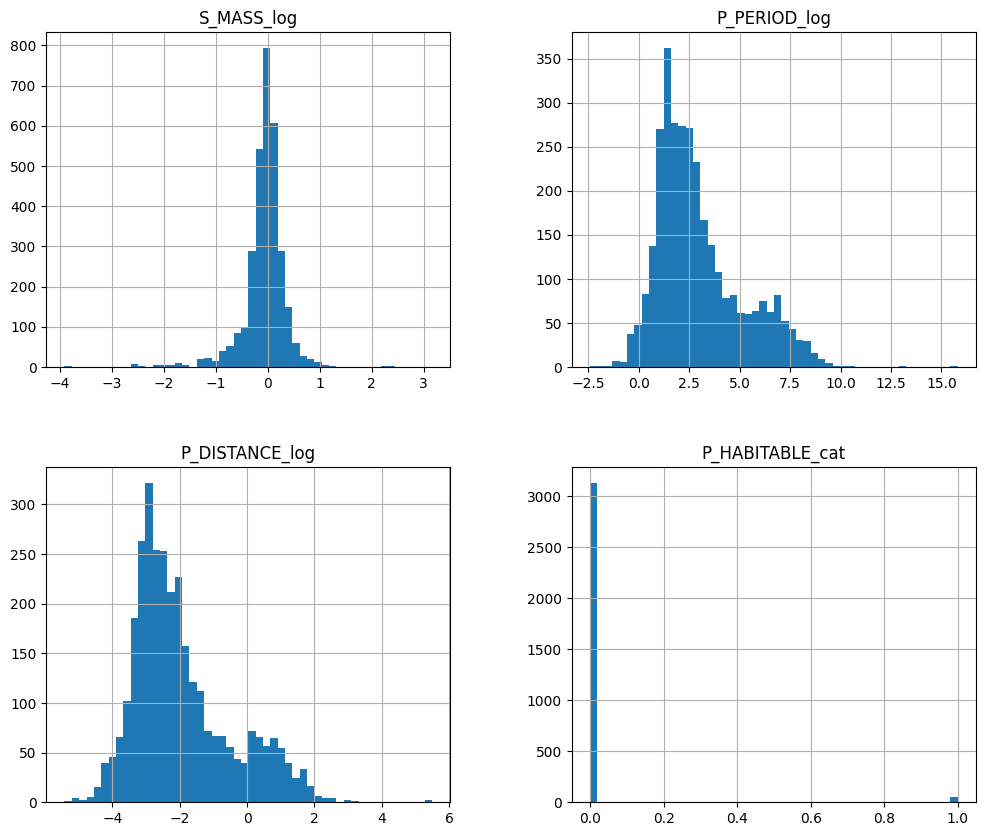

In [ ]:
data_rescaled.hist(bins=50,figsize=(12,10));

In [ ]:
train_set, test_set = train_test_split(data_rescaled, test_size=0.2,
                                       stratify=data_rescaled.P_HABITABLE_cat,
                                       random_state=8964)

In [ ]:
X_train = train_set.drop('P_HABITABLE_cat', axis=1)
y_train = train_set['P_HABITABLE_cat'].copy()
X_test = test_set.drop('P_HABITABLE_cat', axis=1)
y_test = test_set['P_HABITABLE_cat'].copy()

# Train and evaluate a SGD classifier

In [ ]:
sgd_clf = SGDClassifier(random_state=8964)

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [ ]:
confusion_matrix


array([[2494,    8],
       [  39,    3]])

In [ ]:
f1 = f1_score(y_train, y_train_pred)
f1

0.11320754716981132

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

Text(0.95, 0.95, 'F1 score = 0.113\nAUC = 0.092')

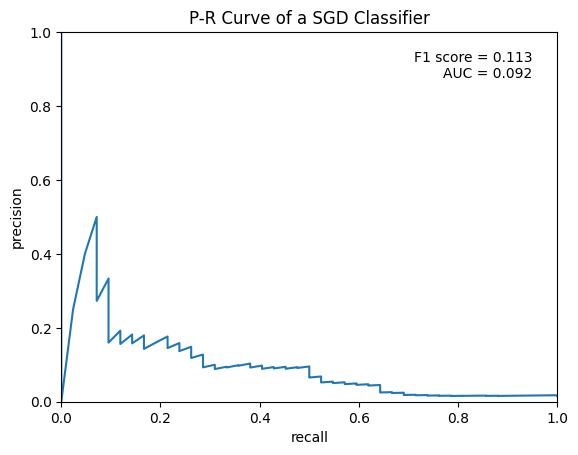

In [ ]:
fig, ax = plt.subplots()
ax.plot(recalls, precisions)
ax.set(xlabel='recall', ylabel='precision',
       title='P-R Curve of a SGD Classifier',
       xlim=[0, 1], ylim=[0, 1])
ax.text(0.95, 0.95,
        'F1 score = {:.3f}\nAUC = {:.3f}'.format(f1, auc(recalls, precisions)),
        ha='right', va='top',
        transform=ax.transAxes)

# Train and evaluate a RandomForest classifier

In [ ]:
forest_clf = RandomForestClassifier(random_state=8964)

In [ ]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)

In [ ]:
confusion_matrix(y_train, y_train_pred)

array([[2493,    9],
       [  32,   10]])

In [ ]:
f1 = f1_score(y_train, y_train_pred)
f1

0.32786885245901637

In [ ]:
y_scores = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

Text(0.95, 0.95, 'F1 score = 0.328\nAUC = 0.416')

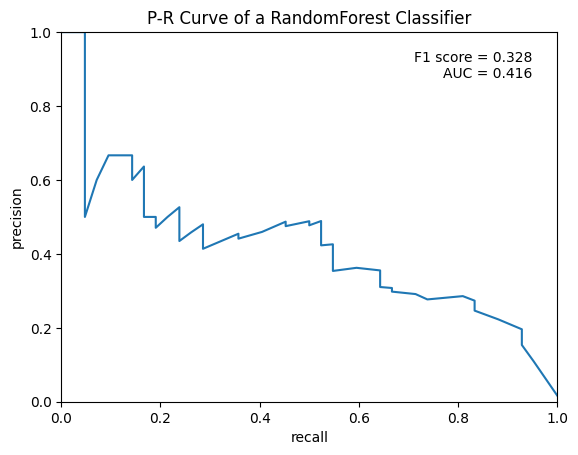

In [ ]:
fig, ax = plt.subplots()
ax.plot(recalls, precisions)
ax.set(xlabel='recall', ylabel='precision',
       title='P-R Curve of a RandomForest Classifier',
       xlim=[0, 1], ylim=[0, 1])
ax.text(0.95, 0.95,
        'F1 score = {:.3f}\nAUC = {:.3f}'.format(f1, auc(recalls, precisions)),
        ha='right', va='top',
        transform=ax.transAxes)

# Conclusion

Without much tuning, the RandomForest classifier performs considerably better than a SGD classifier as the F1 score and the AUC of the P-R curve is much better.